Compares results from stochastic parameter sampling with MOOSE and RoadRunner.

Credit to Subhasis Ray and Upinder Bhalla for contributing to these results. 

In [1]:
from IPython.display import display
import json
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import os
import pandas as pd
from roadrunner import RoadRunner
from tqdm.auto import tqdm
from typing import Dict, List, Optional
import xarray

import libssr

# MOOSE Data Import

In [10]:
root_dir = os.path.join('results', 'compare_moose2')
ssr_dir = os.path.join(root_dir, 'ssr')
plotted_names = [
    ['MAPK', 'MKKK', 'MKK', 'MKKK_P'],
    ['MKK_P', 'MAPK_P', 'MKK_PP', 'MAPK_PP']
]

class MooseSSR:
    """Interface to Moose data with lazy loading and select convenience utilities"""

    def __init__(self, _sdir: str):
        
        self.sdir = _sdir

    def __lt__(self, other):
        return self.sample_size < other.sample_size

    @property
    def data(self):
        return xarray.open_zarr(os.path.join(root_dir, 'data', self.sdir, 'Kholodenko.zarr'))

    @property
    def species(self):
        return list(self.data.species.values)

    @property
    def time(self):
        return self.data.time.to_numpy()

    @property
    def sample_size(self):
        return len(self.data.Kb)

    @property
    def results(self):
        data = self.data
        return {n: np.array(data.conc[:, i, :]) for i, n in enumerate(self.species)}

    @property
    def results_shuffled(self):
        inds = list(range(self.sample_size))
        np.random.shuffle(inds)
        data = self.data
        return {n: np.array(data.conc[inds, i, :]) for i, n in enumerate(self.species)}

    @property
    def efect_report_fp(self):
        return os.path.join(ssr_dir, f'efect_report_{self.sdir}.json')

    @property
    def error_samples_fp(self):
        return os.path.join(ssr_dir, f'error_samples_{self.sdir}.csv')

    @property
    def has_ssr_data(self) -> bool:
        return os.path.isfile(self.efect_report_fp) and os.path.isfile(self.error_samples_fp)

    def save_data(self, _efect_report: libssr.EFECTReport, _error_samples: List[float]):
        with open(self.efect_report_fp, 'w') as f:
            json.dump(_efect_report.to_json(), f, indent=4)
        with open(self.error_samples_fp, 'w') as f:
            pd.Series(_error_samples).to_csv(f)

    @property
    def efect_report(self) -> Optional[libssr.EFECTReport]:
        if os.path.isfile(self.efect_report_fp):
            with open(self.efect_report_fp, 'r') as f:
                return libssr.EFECTReport.from_json(json.load(f))

    @property
    def error_samples(self) -> Optional[List[float]]:
        if os.path.isfile(self.error_samples_fp):
            with open(self.error_samples_fp, 'r') as f:
                return pd.read_csv(f).values[:, 1].tolist()

    def _repr_html_(self):
        return self.data._repr_html_()

    def plot(self, fig_axs=None, plot_kwargs=None):
        if fig_axs is None:
            fig, axs = plt.subplots(len(plotted_names), len(plotted_names[0]), 
                                    layout='compressed', 
                                    figsize=(3.0 * len(plotted_names[0]), 2 * len(plotted_names)), 
                                    sharex=True)
        else:
            fig, axs = fig_axs
        results = self.results
        _plot_kwargs = dict(
            alpha=0.01,
            color='blue'
        )
        if plot_kwargs is not None:
            _plot_kwargs.update(plot_kwargs)
        for i in range(len(plotted_names)):
            for j, n in enumerate(plotted_names[i]):
                axs[i][j].plot(self.time, results[n].T, **_plot_kwargs)
                axs[i][j].set_title(n)
                axs[i][j].set_xlabel('Time')
        return fig, axs


subdirs = [f for f in os.listdir(os.path.join(root_dir, 'data')) if f.startswith('moose_')]
moose_results = list(sorted([MooseSSR(sdir) for sdir in subdirs]))

[display(mr) for mr in moose_results]

var_names = list(moose_results[0].species)

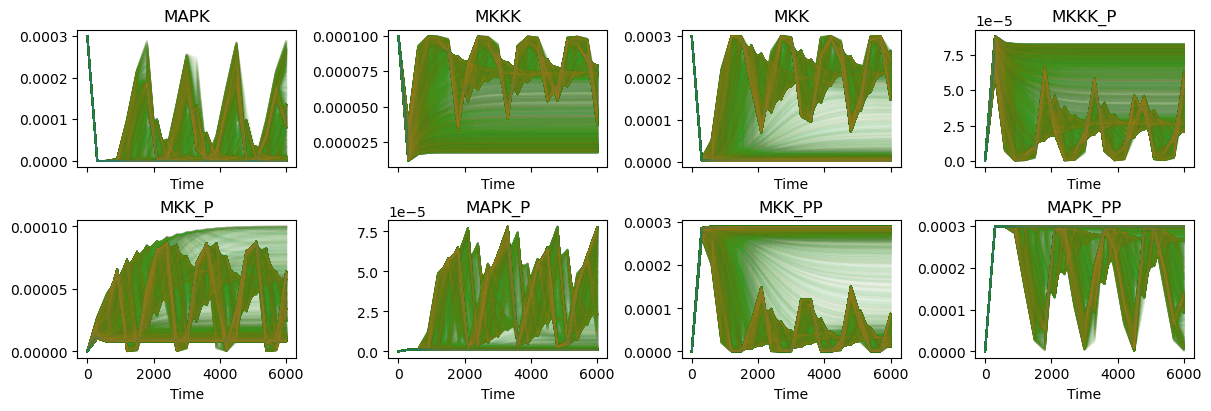

In [11]:
fig_axs = None
for i, mr in enumerate(moose_results):
    fig_axs = mr.plot(fig_axs=fig_axs, 
                      plot_kwargs=dict(color=list(mcolors.TABLEAU_COLORS.values())[i],
                                       zorder=100 - i))

# EFECT Report Generation

In [12]:
eval_num = 100
sig_figs = 16

def generate_efect_report(_sim_times, _results):
    var_names = list(_results.keys())
    num_steps = len(_sim_times)
    sample_size = _results[var_names[0]].shape[0]
    err_samples = libssr.test_reproducibility({k: libssr.round_arr_to_sigfigs(v, sig_figs) for k, v in _results.items()})[0]
    err_means = np.mean(err_samples)
    err_stdevs = np.std(err_samples)
    export_sample_size = sample_size // 2
    ecf_evals = np.ndarray((num_steps, len(var_names), eval_num, 2), dtype=float)
    ecf_tval = np.ndarray((num_steps, len(var_names)), dtype=float)
    for i, n in enumerate(var_names):
        sample_n = _results[n]
        for j in range(num_steps):
            sample_j = sample_n[:export_sample_size, j]
            ecf_tval[j, i] = libssr.eval_final(sample_j)
            ecf_evals[j, i, :, :] = libssr.ecf(sample_j, libssr.get_eval_info_times(eval_num, ecf_tval[j, i]))
    efect_report = libssr.EFECTReport.create(
        variable_names=var_names,
        simulation_times=_sim_times,
        sample_size=export_sample_size,
        ecf_evals=ecf_evals,
        ecf_tval=ecf_tval,
        ecf_nval=eval_num,
        error_metric_mean=err_means,
        error_metric_stdev=err_stdevs,
        sig_figs=sig_figs
    )
    return efect_report, err_samples

if not os.path.isdir(ssr_dir):
    os.makedirs(ssr_dir)

In [13]:
for mr in tqdm(moose_results, desc='Generating libSSR data'):
    if not mr.has_ssr_data:
        mr.save_data(*generate_efect_report(mr.time, mr.results_shuffled))

for mr in moose_results:
    er = mr.efect_report
    print(mr.sdir, er.error_metric_mean, er.error_metric_stdev)

Generating libSSR data:   0%|          | 0/3 [00:00<?, ?it/s]

moose_100 0.5374268968268732 0.06331783123798636
moose_1k 0.1699185049740024 0.020013885388098583
moose_10k 0.053903046879501156 0.006550609923332974


# RoadRunner comparison

In [14]:
name_map = {
    'MAPK': 'MAPK_458_0_',
    'MAPK_PP': 'MAPK_PP_508_0_',
    'MAPK_P': 'MAPK_P_484_0_',
    'MKKK': 'MKKK_460_0_',
    'MKKK_P': 'MKKK_P_468_0_',
    'MKK': 'MKK_462_0_',
    'MKK_PP': 'MKK_PP_502_0_',
    'MKK_P': 'MKK_P_482_0_'
}
name_map_i = {v: k for k, v in name_map.items()}

sbml_fp = os.path.join(root_dir, 'data', 'Kholodenko_tosbml.xml')
rr = RoadRunner(RoadRunner.getParamPromotedSBML(sbml_fp))
rng = np.random.default_rng(0)


def generate_rr_results(_mr: MooseSSR):

    sz = _mr.sample_size // 2
    times = _mr.time
    results_rr = {n: np.zeros((sz, times.shape[0])) for n in var_names}

    for i, kb in tqdm(enumerate(rng.uniform(1E-3, 0.05, size=sz)), total=sz, leave=False):
        rr.resetToOrigin()

        rr['Neg_feedback_500_0__Neg_feedback_500_0__Kb'] = kb
        res = rr.simulate(times=times)
        for n in var_names:
            results_rr[n][i, :] = res[:, res.colnames.index(f'[{name_map[n]}]')]

    return results_rr

def compare_rr_moose(_mr: MooseSSR, _rr_results: Dict[str, np.ndarray]):

    efect_report = _mr.efect_report
    error_samples = _mr.error_samples
    efect_error = -1.
    max_name = None
    max_idx = None

    for i, n in enumerate(efect_report.variable_names):
        sample_n = _rr_results[n]
        for j in range(len(efect_report.simulation_times)):
            eval_t = libssr.get_eval_info_times(efect_report.ecf_nval, efect_report.ecf_tval[j, i])
            ecf_report = efect_report.ecf_evals[j, i, :, :]

            ecf = libssr.ecf(libssr.round_arr_to_sigfigs(sample_n.T[j, :], efect_report.sig_figs), eval_t)
            err = libssr.ecf_compare(ecf, ecf_report)
            if err > efect_error:
                efect_error = err
                max_name = n
                max_idx = j

    pval_not_reproduced = libssr.pval(error_samples, efect_error)

    return efect_error, pval_not_reproduced, max_name, max_idx

sig_level = 0.05

efect_errors = []
pvals_not_reproduced = []
max_names = []
max_indices = []

for mr in tqdm(moose_results, desc='Comparing results'):
    err, pval, max_name, max_idx = compare_rr_moose(mr, generate_rr_results(mr))
    efect_errors.append(err)
    pvals_not_reproduced.append(pval)
    max_names.append(max_name)
    max_indices.append(max_idx)

for mr, err, pval in zip(moose_results, efect_errors, pvals_not_reproduced):
    print(f'{mr.sdir}:', 'Reproduced' if pval > sig_level else 'Not reproduced', f'({err}, {pval})')

Comparing results:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

moose_100: Reproduced (0.40553798076252123, 1.0)
moose_1k: Reproduced (0.1841285324763803, 1.0)
moose_10k: Reproduced (0.05629072468790354, 1.0)


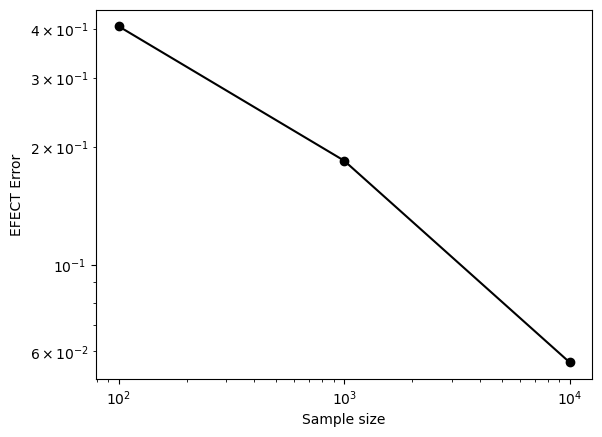

In [15]:
plt.plot([mr.sample_size for mr in moose_results], efect_errors, color='black', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample size')
_ = plt.ylabel('EFECT Error')

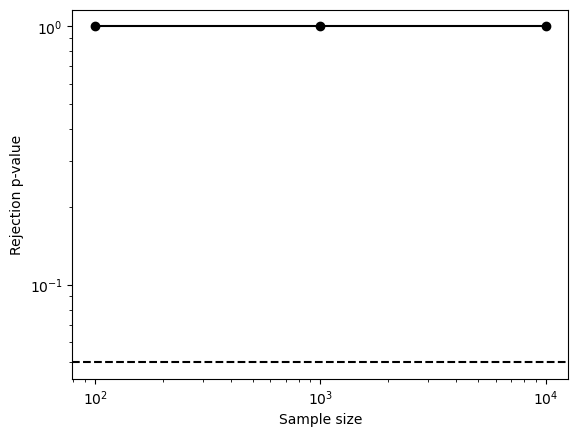

In [16]:
plt.plot([mr.sample_size for mr in moose_results], pvals_not_reproduced, color='black', marker='o')
plt.axhline(sig_level, color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sample size')
_ = plt.ylabel('Rejection p-value')